In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.utils import np_utils


class NeuralNetwork:
    def __init__(self):
        self.error_per_epoch = []
        self.layers = []
        self.loss = None
        self.loss_prime = None

    def add(self, layer):
        self.layers.append(layer)

    def loss_function(self, loss, loss_prime):
        self.loss = loss
        self.loss_prime = loss_prime

    def predict(self, input_data):
        result = []
        for i in range(len(input_data)):
            output = input_data[i]
            for layer in self.layers:
                output = layer.forward_propagation(output)
            result.append(output)
        return result

    def fit(self, x_train, y_train, epochs, learning_rate):
        sample_length = len(x_train)
        # Iterating over every epoch to train the model.
        for i in range(epochs):
            err = 0
            for j in range(sample_length):
                # Invoke forward propagation for every record in the training dataset
                output = x_train[j]
                for layer in self.layers:
                    output = layer.forward_propagation(output)
                err += self.loss(y_train[j], output)

                # Invoke backward propagation for every record in the training dataset
                error = self.loss_prime(y_train[j], output)
                for layer in reversed(self.layers):
                    # Setting momentum to be 0.1 for backward propagation function in every layer 
                    error = layer.backward_propagation(error, learning_rate, momentum=0.1)

            # calculate average error on all samples
            err /= sample_length
            self.error_per_epoch.append(err)


class Layer:
    # Random initialization of input variables
    def __init__(self, input_size, output_size):
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5
        self.weights_error_prev = 0

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.output

    # updates the weights for every iteration using Stochastic gradient descent algorithm 
    def backward_propagation(self, output_error, learning_rate, momentum):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)
        self.weights -= learning_rate * weights_error + momentum*self.weights_error_prev
        self.bias -= learning_rate * output_error
        # weight error in the previous iteration to calculate the new weight value with momentum hyper-parameter
        self.weights_error_prev = weights_error
        return input_error


class ActivationLayer:
    def __init__(self, activation, activation_prime):
        self.activation = activation
        self.activation_prime = activation_prime

    # Applies the desired activation function and returns the activated input value.
    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output
    def backward_propagation(self, output_error, learning_rate, momentum):
        return self.activation_prime(self.input) * output_error


In [11]:
# Loss Funtion
def cross_entropy(y_true, y_pred):
    return -sum([y_true[i] * np.log2(y_pred[0][i]) for i in range(y_true.size)])


def cross_entropy_prime(y_true,y_pred):
    return y_pred - y_true

#Activation Funtion

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def sigmoid_prime(x):
    s = 1 / (1 + np.exp(-x))
    return s * (1 - s)

def accuracy(y_test, y_pred):
    """Function to calculate the accuracy of predicted values"""
    correct = 0
    for i in range(len(y_test)):
        actual_value = np.argmax(y_test[i])
        predicted_value = np.argmax(y_pred[i])
        if actual_value == predicted_value:
            correct += 1
    acc = (correct / len(y_test)) * 100
    return acc

In [12]:
dataset = pd.read_csv("winequality-red.csv", sep=';')
data = dataset.iloc[:, :11]
target = dataset[["quality"]]
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=3)
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)
X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

In [13]:
X_train = X_train.reshape(X_train.shape[0], 1, 11)
y_train = np_utils.to_categorical(y_train, num_classes=11)
X_test = X_test.reshape(X_test.shape[0], 1, 11)
y_test = np_utils.to_categorical(y_test, num_classes=11)


Enter number of hidden layers required in the Neural Network: 1
Test accuracy is 60.5


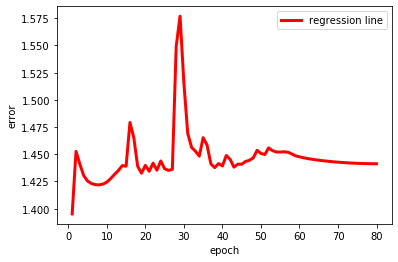

In [15]:
net = NeuralNetwork()
# Add the first layer with 11 input features and 5 intermediatary nodes
net.add(Layer(11, 5))
# Fetch inputs from user for number of hidden layers and activation function 
hidden_layers = int(input("Enter number of hidden layers required in the Neural Network: "))

# Create number of hidden layers as inputted by user
for x in range(1, hidden_layers + 1):
    # Final output layer with 11 classes (rating 0 to 11)
    if x == hidden_layers:
        net.add(Layer(5, 11))
    else:
        net.add(Layer(5, 5))
    net.add(ActivationLayer(sigmoid, sigmoid_prime))
net.loss_function(cross_entropy, cross_entropy_prime)
epochs = 80
net.fit(X_train, y_train, epochs=epochs, learning_rate=0.05)

# Predict the output values of Testing dataset
y_pred = net.predict(X_test)
print(f"Test accuracy is {accuracy(y_test, y_pred)}")

# Plot the graph Loss/ epoch
plt.plot(range(1, epochs + 1), net.error_per_epoch, color='red', linewidth=3, label='regression line')
plt.xlabel('epoch')
plt.ylabel('error')
plt.legend()
plt.show()

